In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta, time, datetime
import time
from statsmodels.tsa.seasonal import seasonal_decompose

## Only run on weekends once

In [101]:
today = date.today()
day = today.weekday()
week_start = today - timedelta(days = day)
if day > 4:
    print(f'Ok to continue for week {week_start}')
else:
    raise Exception('Not on weekend, please wait until weekend to run.')
weekend = today

Ok to continue for week 2021-05-17


Edit below next weekend

In [84]:
print(today)

2021-05-16


In [102]:
cptv_week_df = pd.DataFrame()
rtt_week_df = pd.DataFrame()

for day_num in range(5):
    trading_day = today - timedelta(days = day-day_num)
    
    cptv_trading_day_path = f'closing_price_trade_volume_data/AMZN_cptv_{trading_day}.xls'
    cptv_trading_day_df = pd.read_excel(cptv_trading_day_path)
    cptv_trading_day_df.drop(columns=['Open', 'High', 'Low'], inplace=True)
    cptv_trading_day_df.drop(cptv_trading_day_df.tail(1).index, inplace=True)
    cptv_week_df = cptv_week_df.append(cptv_trading_day_df, ignore_index=True, sort=False)
    
    rtt_trading_day_path = f'real_time_trades_data/AMZN_rtt_{trading_day}.csv'
    rtt_trading_day_df = pd.read_csv(rtt_trading_day_path)
    rtt_trading_day_df.drop(columns=['Unnamed: 0'], inplace=True)
    rtt_week_df = rtt_week_df.append(rtt_trading_day_df, ignore_index=True, sort=False)

rtt_week_df['NLS Price'] = rtt_week_df['NLS Price'].map(lambda x: x.lstrip('$ '))
rtt_week_df['NLS Price'] = pd.to_numeric(rtt_week_df['NLS Price'])
rtt_week_df['NLS Share Volume'] = rtt_week_df['NLS Share Volume'].str.replace(',', '')
rtt_week_df['NLS Share Volume'] = pd.to_numeric(rtt_week_df['NLS Share Volume'])

cptv_week_csv = f'AMZN_cptv_{week_start}.csv'
cptv_week_df.to_csv(path_or_buf=f'C:/Users/seant/stock_analyzer/weekly_data/{cptv_week_csv}')
rtt_week_csv = f'AMZN_rtt_{week_start}.csv'
rtt_week_df.to_csv(path_or_buf=f'C:/Users/seant/stock_analyzer/weekly_data/{rtt_week_csv}')

In [103]:
week_start = '2021-05-10'

In [144]:
cptv_week_csv = f'AMZN_cptv_{week_start}.csv'
cptv_week_df = pd.read_csv(f'C:/Users/seant/stock_analyzer/weekly_data/{cptv_week_csv}', header=0, index_col=0)
rtt_week_csv = f'AMZN_rtt_{week_start}.csv'
rtt_week_df = pd.read_csv(f'C:/Users/seant/stock_analyzer/weekly_data/{rtt_week_csv}', header=0, index_col=0)

In [105]:
cptv_week_df['Close'].corr(cptv_week_df['Volume'])

0.03799743365257477

In [119]:
grouped_cptv_week_df = cptv_week_df.groupby(np.arange(len(cptv_week_df))//30).mean()
grouped_cptv_week_df = grouped_cptv_week_df.loc[np.repeat(grouped_cptv_week_df.index.values,30)]

In [120]:
grouped_cptv_week_df.head()

,Unnamed: 0,Close,Volume,rolling_close,rolling_volume
0,14.5,3250.815163,31102.300000,NaN,NaN
1,44.5,3233.172607,20152.733333,3234.855707,22120.226667
2,74.5,3224.522870,19040.300000,3224.671280,18563.176111
3,104.5,3213.543383,16599.233333,3216.687038,17265.819444
4,134.5,3219.370413,14470.166667,3218.691950,13441.675556


In [145]:
close_price_series = cptv_week_df.loc[:, 'Close']
cptv_week_df = cptv_week_df.assign(rolling_close = close_price_series.rolling(180, center=True).mean())
close_volume_series = cptv_week_df.loc[:, 'Volume']
cptv_week_df = cptv_week_df.assign(rolling_volume = close_volume_series.rolling(180, center=True).mean())

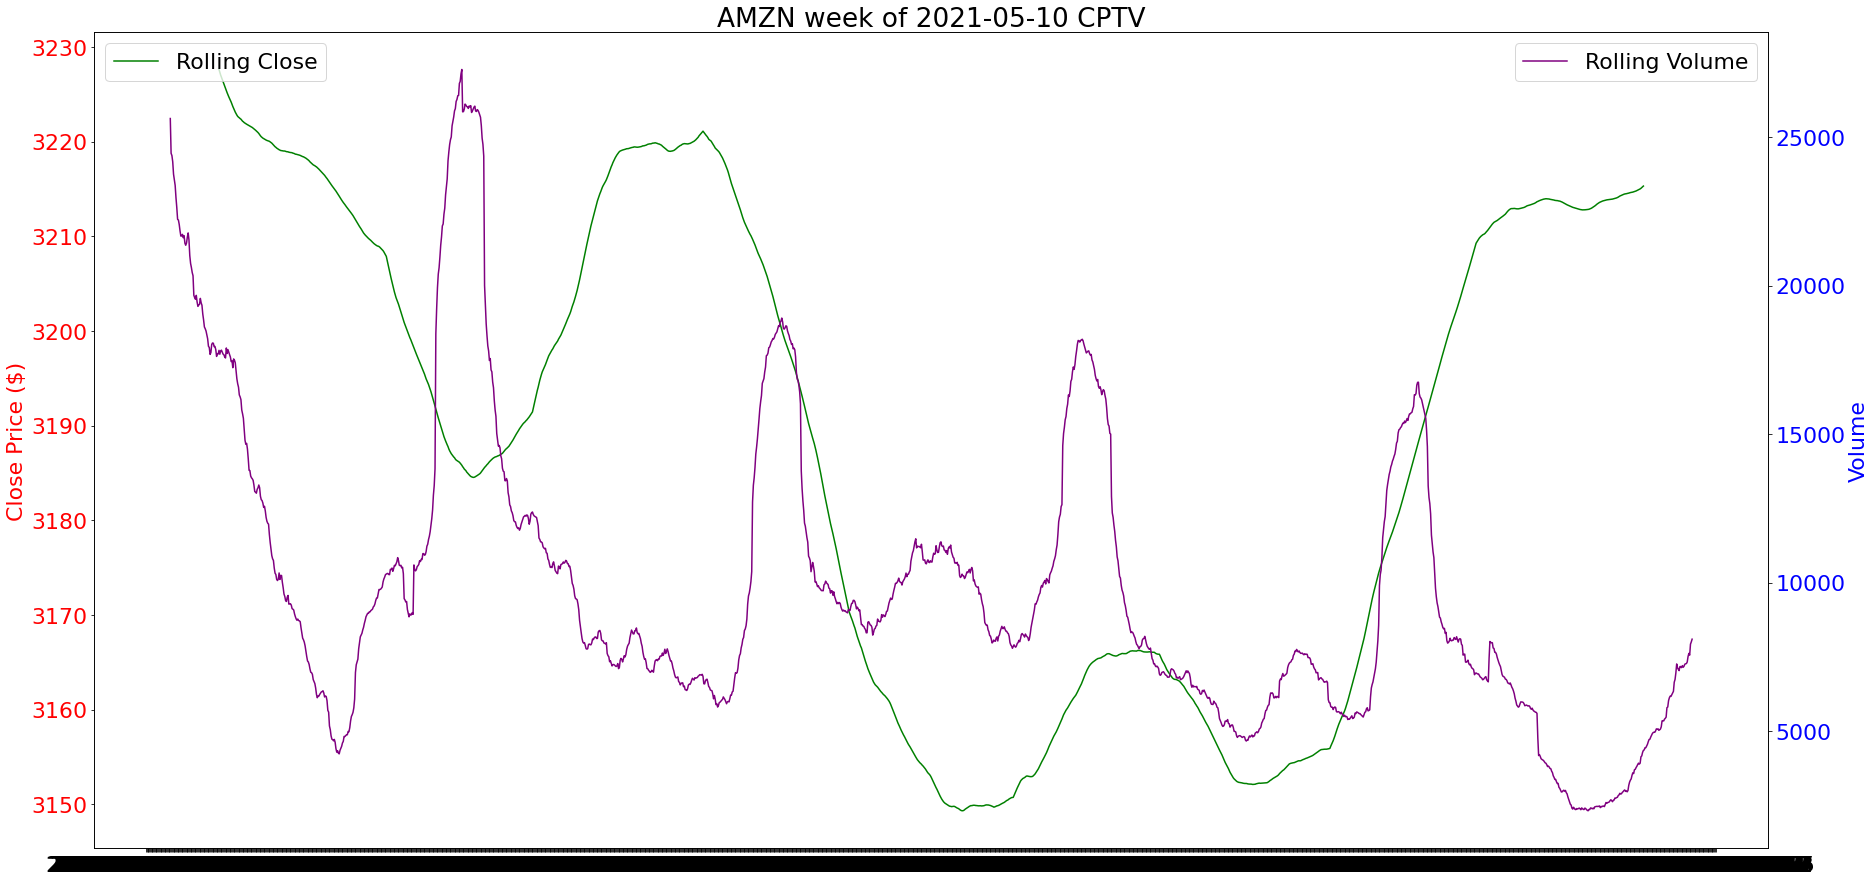

In [126]:
date_array = cptv_week_df.loc[:, 'Date']

plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(1, figsize=(30, 15))

#ax1.plot(date_array, cptv_week_df.loc[:, 'Close'], color='r', label='Close')
ax1.plot(date_array, cptv_week_df.loc[:, 'rolling_close'], color='g', label='Rolling Close')
ax1.set_ylabel('Close Price ($)', color ='r')
ax1.set_title(f'AMZN week of {week_start} CPTV')
ax1.tick_params(axis='y', labelcolor='r')
ax1.legend(loc = 'upper left')

ax2 = ax1.twinx()
#ax2.plot(date_array, cptv_week_df.loc[:, 'Volume'], color='b', label='Volume')
ax2.plot(date_array, week_df.loc[:, 'rolling_volume'], color='purple', label='Rolling Volume')
ax2.set_ylabel('Volume', color ='b')
ax2.tick_params(axis='y', labelcolor='b')
ax2.legend()

plt.show()

In [129]:
cptv_week_df.head()

,Unnamed: 0,Date,Close,Volume,rolling_close,rolling_volume
0,0,2021-05-10 09-30,3273.1101,98924.0,NaN,NaN
1,1,2021-05-10 09-31,3269.8450,21831.0,NaN,NaN
2,2,2021-05-10 09-32,3259.7500,30404.0,NaN,NaN
3,3,2021-05-10 09-33,3259.0000,45721.0,NaN,NaN
4,4,2021-05-10 09-34,3258.0000,32843.0,NaN,NaN


In [150]:
cptv_roll_close_for_decompose = cptv_week_df[['rolling_close']].dropna().reset_index(drop=True)
cptv_roll_vol_for_decompose = cptv_week_df[['rolling_volume']].dropna().reset_index(drop=True)

In [156]:
dta = sm.datasets.co2.load_pandas().data
dta.co2.interpolate(inplace=True)
res = sm.tsa.seasonal_decompose(dta.co2)

def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')


dta = sm.datasets.co2.load_pandas().data
dta.co2.interpolate(inplace=True)
res = sm.tsa.seasonal_decompose(dta.co2)

fig, axes = plt.subplots(ncols=3, nrows=4, sharex=True, figsize=(12,5))

plotseasonal(res, axes[:,0])
plotseasonal(res, axes[:,1])
plotseasonal(res, axes[:,2])

plt.tight_layout()
plt.show()

<class 'statsmodels.tsa.seasonal.DecomposeResult'>


In [163]:
def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

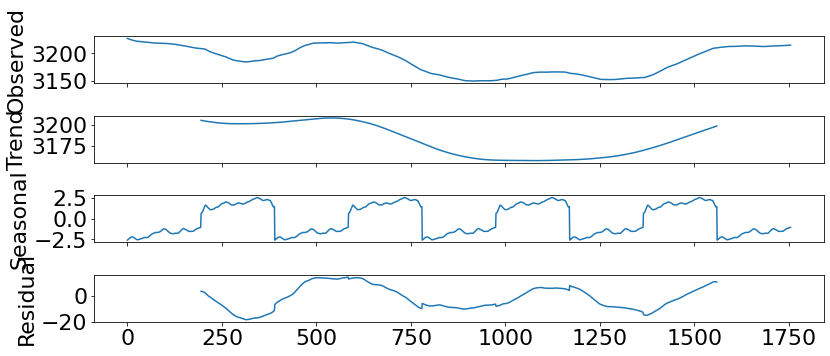

In [166]:
fig, axes = plt.subplots(nrows = 4, sharex = True, figsize=(12,5))
decomposed_cptv_roll_close = seasonal_decompose(cptv_roll_close_for_decompose, model='additive', period=390)

plotseasonal(decomposed_cptv_roll_close, axes[:])

plt.tight_layout()
plt.show()

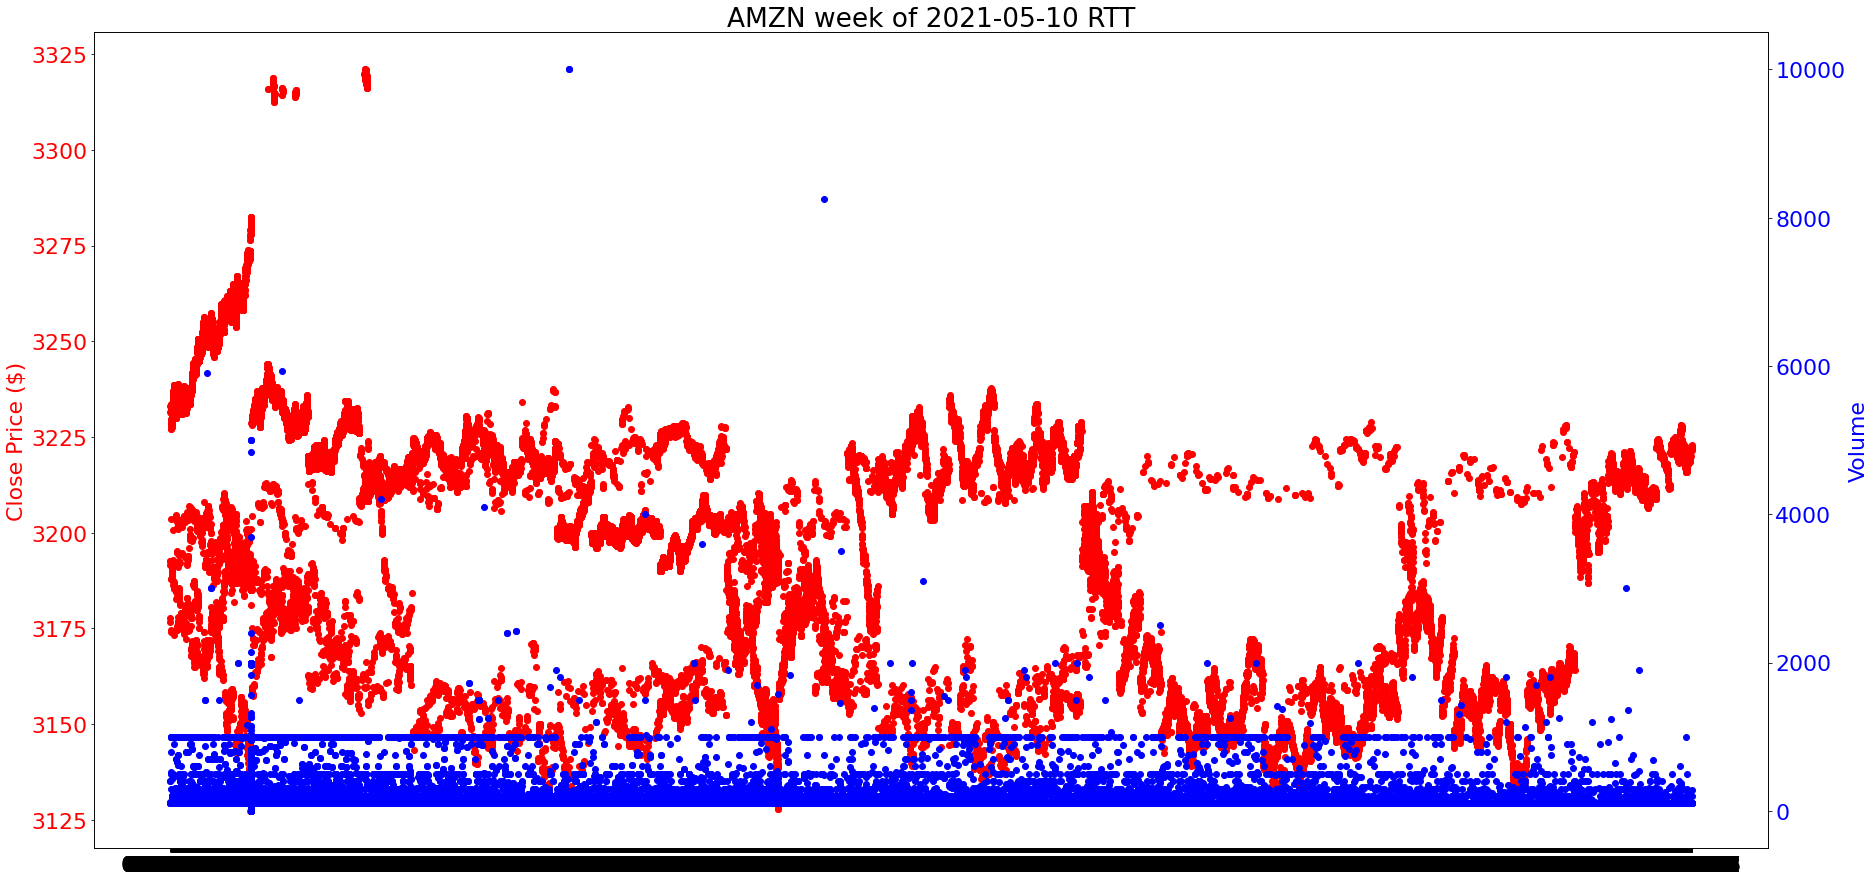

In [47]:
date_array = rtt_week_df.loc[:, 'NLS Time (ET)']

plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(1, figsize=(30, 15))

ax1.scatter(date_array, rtt_week_df.loc[:, 'NLS Price'], color='r', alpha=0.5, label='NLS Price')
ax1.set_ylabel('Price ($)', color ='r')
ax1.set_title(f'AMZN week of {week_start} RTT')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.scatter(date_array, rtt_week_df.loc[:, 'NLS Share Volume'], color='b', alpha=0.5, label='NLS Share Volume')
ax2.set_ylabel('Volume', color ='b')
ax2.tick_params(axis='y', labelcolor='b')

plt.show()